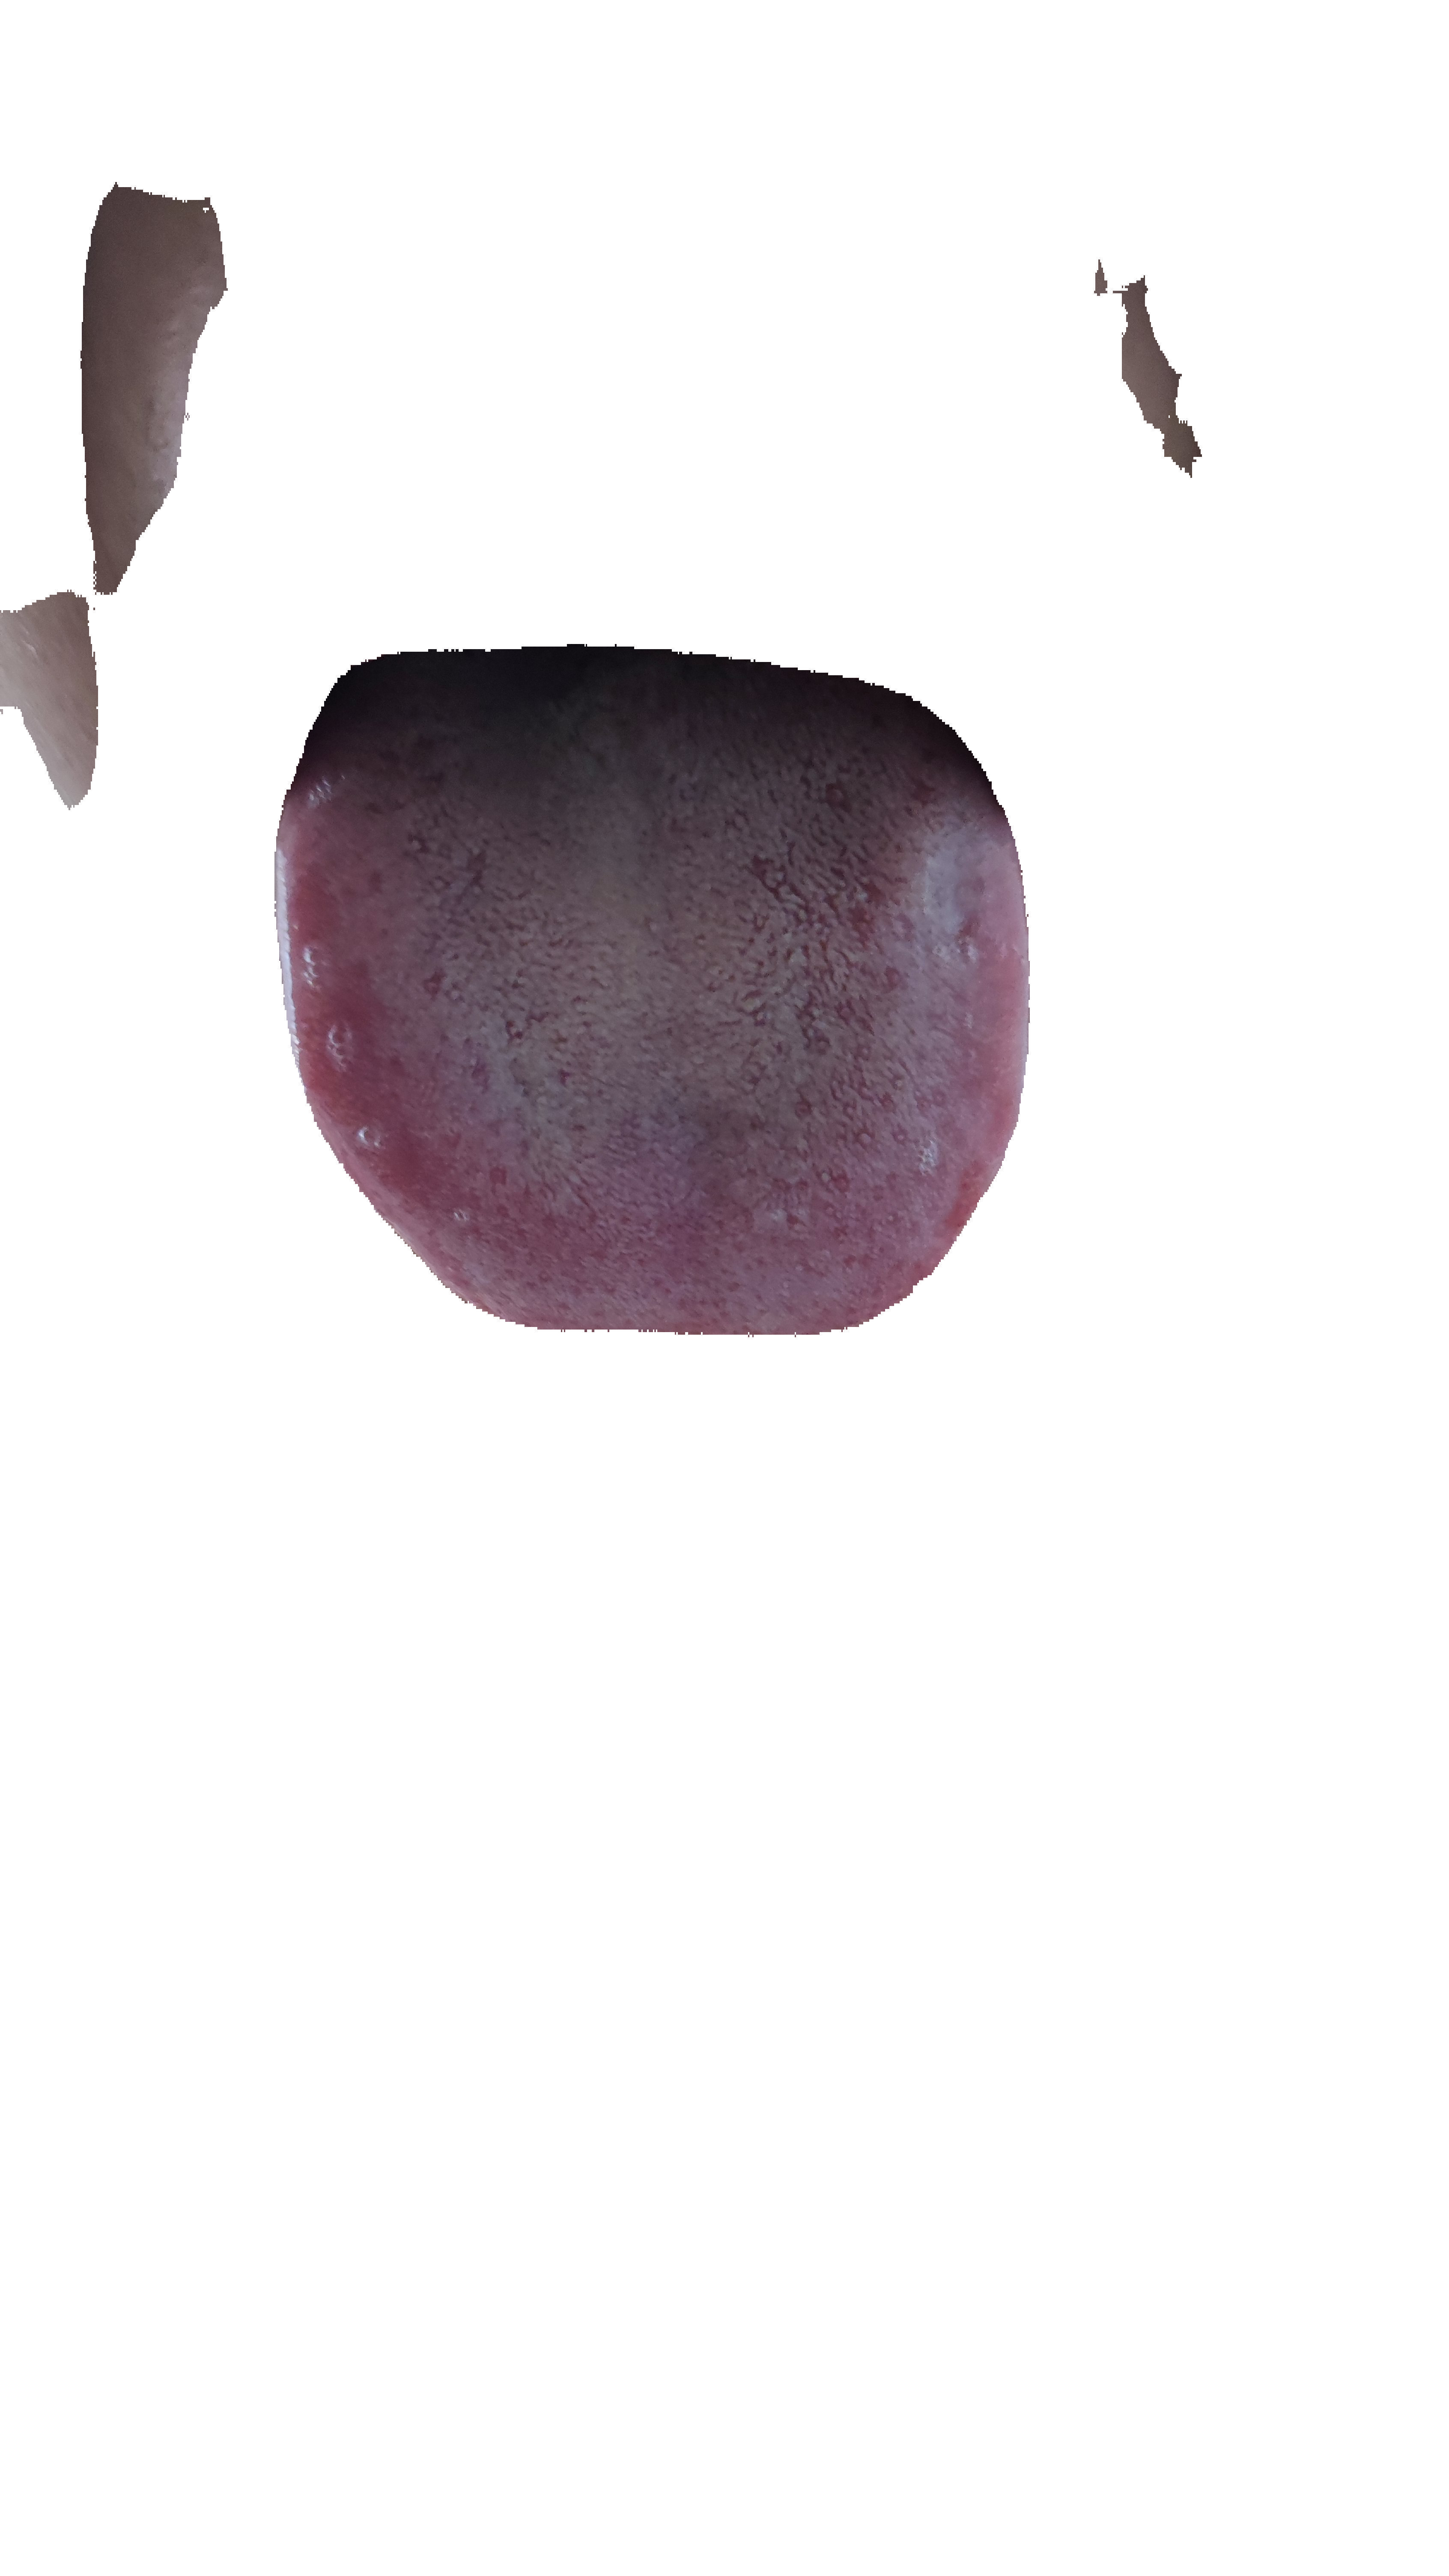

In [23]:
import torch
import torch.nn as nn
from torchvision import models
import numpy as np
from PIL import Image
from torchvision import transforms


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# 定义基于VGG16的FCN网络
class VGG16_FCN(nn.Module):
    def __init__(self, num_classes):
        super(VGG16_FCN, self).__init__()
        # 加载预训练的VGG16模型
        vgg16 = models.vgg16(
            weights=models.VGG16_Weights.DEFAULT)

        # 取出VGG16的前面部分（去掉全连接层）
        self.features = vgg16.features

        # 用1x1卷积替换VGG16的全连接层
        self.conv6 = nn.Conv2d(512, 4096, kernel_size=5, padding=2)
        self.relu6 = nn.ReLU(inplace=True)
        self.dropout6 = nn.Dropout2d()
        self.conv7 = nn.Conv2d(4096, 4096, kernel_size=3, padding=1)
        self.relu7 = nn.ReLU(inplace=True)
        self.dropout7 = nn.Dropout2d()

        # 最后的卷积层用于生成分割结果
        self.score_fr = nn.Conv2d(4096, num_classes, kernel_size=1)
        self.upscore = nn.ConvTranspose2d(
            num_classes, num_classes, kernel_size=64, stride=32, padding=16, bias=False)

        # 初始化上采样层权重
        self.upscore.weight.data.fill_(0)
        self.upscore.weight.data[:, :, 16, 16] = 1  # 双线性插值

    def forward(self, x):
        # 前向传播
        x = self.features(x)
        x = self.relu6(self.conv6(x))
        x = self.dropout6(x)
        x = self.relu7(self.conv7(x))
        x = self.dropout7(x)
        x = self.score_fr(x)
        x = self.upscore(x)
        return x


def get_segmentation_mask(model, image_path):

    model.eval()

    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((1000, 1000)),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                            #  0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0)
    image = image.to(device)
    with torch.no_grad():
        output = model(image)
    output = torch.sigmoid(output)
    output = torch.argmax(output, dim=1)
    mask = output.squeeze().cpu().numpy()
    return mask


def post_process(mask, model):
    # Post process the mask
    model.load_state_dict(torch.load('vgg16_fcn_on_mask_9_3.pth'))
    model.eval()
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((2000, 2000)),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
        #  0.229, 0.224, 0.225])
    ])
    mask = transform(mask).unsqueeze(0)
    mask = mask.to(device)
    with torch.no_grad():
        output = model(mask)
    output = torch.sigmoid(output)
    output = torch.argmax(output, dim=1)
    mask = output.squeeze().cpu().numpy()
    return mask

# Get segmentation mask for a sample image


image_path = './data/test/label_data/test1.jpg'  # Replace with your image path
# image_path = r'data\split_dataset_ultra\images\tongue_front_300137871001_2023-11-06-15-10-33.png_cc645bfb-a335-4dfd-99c2-f71a2e45dfa0.png'
# 载入模型权重
model = VGG16_FCN(2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.load_state_dict(torch.load('vgg16_fcn_optim_25_3.pth'))
mask = get_segmentation_mask(model, image_path)
final_mask = np.zeros_like(mask)
final_mask[mask == 0] = 255
final_mask = Image.fromarray(final_mask.astype(np.uint8))


image = Image.open(image_path).convert('RGB')
final_mask = final_mask.resize(image.size, Image.NEAREST)
# 保存 mask
final_mask.save('mask.jpg') 
# 读取 mask
final_mask = Image.open('mask.jpg')

# # 后处理
# mask = post_process(final_mask, model)
# final_mask = np.zeros_like(final_mask)
# final_mask[mask == 0] = 255
# final_mask = Image.fromarray(final_mask.astype(np.uint8))
# image = Image.open(image_path).convert('RGB')
# final_mask = final_mask.resize(image.size, Image.NEAREST)

# 叠加原图
image.paste(final_mask, (0, 0), final_mask)
image

In [2]:
import os
from tqdm import tqdm
import torch
import torch.nn as nn
from torchvision import models
import numpy as np
from PIL import Image
from torchvision import transforms


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# 定义基于VGG16的FCN网络
class VGG16_FCN(nn.Module):
    def __init__(self, num_classes):
        super(VGG16_FCN, self).__init__()
        # 加载预训练的VGG16模型
        vgg16 = models.vgg16(
            weights=models.VGG16_Weights.DEFAULT)

        # 取出VGG16的前面部分（去掉全连接层）
        self.features = vgg16.features

        # 用1x1卷积替换VGG16的全连接层
        self.conv6 = nn.Conv2d(512, 4096, kernel_size=5, padding=2)
        self.relu6 = nn.ReLU(inplace=True)
        self.dropout6 = nn.Dropout2d()
        self.conv7 = nn.Conv2d(4096, 4096, kernel_size=3, padding=1)
        self.relu7 = nn.ReLU(inplace=True)
        self.dropout7 = nn.Dropout2d()

        # 最后的卷积层用于生成分割结果
        self.score_fr = nn.Conv2d(4096, num_classes, kernel_size=1)
        self.upscore = nn.ConvTranspose2d(
            num_classes, num_classes, kernel_size=64, stride=32, padding=16, bias=False)

        # 初始化上采样层权重
        self.upscore.weight.data.fill_(0)
        self.upscore.weight.data[:, :, 16, 16] = 1  # 双线性插值

    def forward(self, x):
        # 前向传播
        x = self.features(x)
        x = self.relu6(self.conv6(x))
        x = self.dropout6(x)
        x = self.relu7(self.conv7(x))
        x = self.dropout7(x)
        x = self.score_fr(x)
        x = self.upscore(x)
        return x


def get_segmentation_mask(model, image_path):

    model.eval()

    image = Image.open(image_path).convert('RGB')
    size = image.size
    transform1 = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((2000, 2000)),
    ])
    transform2 = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((1500, 1500)),
    ])
    transform3 = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((1000, 1000)),
    ])
    transform4 = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((800, 800)),
    ])

    image1 = transform1(image).unsqueeze(0)
    image1 = image1.to(device)
    with torch.no_grad():
        output = model(image1)
    del image1
    output = torch.sigmoid(output)
    output = torch.argmax(output, dim=1)
    output = transforms.Resize(
        size, interpolation=transforms.InterpolationMode.NEAREST)(output)

    image2 = transform2(image).unsqueeze(0)
    image2 = image2.to(device)
    with torch.no_grad():
        temp_output = model(image2)
    del image2
    temp_output = torch.sigmoid(temp_output)
    temp_output = torch.argmax(temp_output, dim=1)
    temp_output = transforms.Resize(
        size, interpolation=transforms.InterpolationMode.NEAREST)(temp_output)
    output = output | temp_output

    image3 = transform3(image).unsqueeze(0)
    image3 = image3.to(device)
    with torch.no_grad():
        temp_output = model(image3)
    del image3
    temp_output = torch.sigmoid(temp_output)
    temp_output = torch.argmax(temp_output, dim=1)
    temp_output = transforms.Resize(
        size, interpolation=transforms.InterpolationMode.NEAREST)(temp_output)
    output = output | temp_output

    image4 = transform4(image).unsqueeze(0)
    image4 = image4.to(device)
    with torch.no_grad():
        temp_output = model(image4)
    del image4
    temp_output = torch.sigmoid(temp_output)
    temp_output = torch.argmax(temp_output, dim=1)
    temp_output = transforms.Resize(
        size, interpolation=transforms.InterpolationMode.NEAREST)(temp_output)
    output = output | temp_output

    mask = output.squeeze().cpu().numpy()
    return mask


def process_input(input_path, output_dir, model):
    if os.path.isfile(input_path):
        process_file(input_path, output_dir, model)
    elif os.path.isdir(input_path):
        for file_name in tqdm(os.listdir(input_path)):
            file_path = os.path.join(input_path, file_name)
            if os.path.isfile(file_path):
                process_file(file_path, output_dir, model)


def process_file(file_path, output_dir, model):
    # Get segmentation mask
    mask = get_segmentation_mask(model, file_path)

    # Create final mask
    final_mask = np.zeros_like(mask)
    final_mask[mask == 0] = 255
    final_mask = Image.fromarray(final_mask.astype(np.uint8))

    # Resize final mask to match original image size
    original_image = Image.open(file_path).convert('RGB')
    final_mask = final_mask.resize(original_image.size, Image.NEAREST)

    # Save mask
    mask_filename = os.path.basename(file_path)
    mask_path = os.path.join(output_dir, mask_filename)
    final_mask.save(mask_path)

    # Optionally, paste mask onto original image
    # original_image.paste(final_mask, (0, 0), final_mask)
    # original_image.save(os.path.join(output_dir, 'masked_' + os.path.basename(file_path)))


# Replace with your input directory or file path
input_path = r'./data\split_dataset_ultra\images'
output_dir = r'./data\split_dataset_ultra2/images'  # Replace with your output directory

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Load model
model = VGG16_FCN(2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.load_state_dict(torch.load('vgg16_fcn_7_3.pth'))

# Process input
process_input(input_path, output_dir, model)

100%|██████████| 1000/1000 [23:30<00:00,  1.41s/it]


In [21]:
import numpy as np
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
import cv2
import numpy as np

# 创建一个示例二值图像
binary_image = np.zeros((100, 100), dtype=np.uint8)
binary_image[10:30, 10:30] = 1  # 在图像中心创建一个小方形物体
binary_image[50:80, 50:80] = 1  # 在图像中心创建另一个小方形物体
binary_image[55:77, 55:77] = 0  # 在图像中心创建另一个小方形物体
binary_image[85:99, 85:99] = 1  # 在图像中心创建另一个小方形物体


# 查找轮廓
contours, _ = cv2.findContours(
    binary_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

# 打印连通域个数
print("连通域个数：", len(contours))

3
连通域个数： 4


In [4]:
import cv2
import numpy as np

# 创建一个示例轮廓（以简单的四边形为例）
contour = np.array([[100, 100], [300, 100], [300, 300], [100, 300]])

print(contour.shape)

# 将轮廓转换为浮点类型
contour_float = contour.astype(np.float32)

# 进行多边形逼近
epsilon = 10  # 设置逼近精度
approx_curve = cv2.approxPolyDP(contour_float, epsilon, closed=True)

# 打印逼近后的多边形顶点坐标
print("逼近后的多边形顶点坐标：")
print(len(approx_curve))

(4, 2)
逼近后的多边形顶点坐标：
4


In [12]:
import numpy as np


test = [(1,2), (3,4), (5,6)]

test1, test2 = zip(*test)
test3 = [i for i in test1]
print(np.mean([]))

nan


c:\Users\ChenXi\.conda\envs\2.2.1_11.8\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ChenXi\.conda\envs\2.2.1_11.8\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [27]:
def flood_fill(image, x, y, target_color, visited, area_perimeter):
    """
    Flood fill algorithm to recursively fill connected components in an image.

    :param image: 2D array representing the image
    :param x: x-coordinate of the starting pixel
    :param y: y-coordinate of the starting pixel
    :param target_color: the color of the pixels to be replaced
    :param replacement_color: the color to replace target_color
    :param visited: set containing visited pixels
    """
    if image[x][y] != target_color:
        return

    visited.add((x, y))
    area_perimeter[0] += 1
    area_perimeter[1] += 4

    if x > 0 and (x - 1, y) not in visited and image[x - 1][y] == target_color:
        area_perimeter[1] -= 1
        flood_fill(image, x - 1, y, target_color, visited, area_perimeter)
    if x < len(image) - 1 and (x + 1, y) not in visited and image[x + 1][y] == target_color:
        area_perimeter[1] -= 1
        flood_fill(image, x + 1, y, target_color, visited, area_perimeter)
    if y > 0 and (x, y - 1) not in visited and image[x][y - 1] == target_color:
        area_perimeter[1] -= 1
        flood_fill(image, x, y - 1, target_color, visited, area_perimeter)
    if y < len(image[0]) - 1 and (x, y + 1) not in visited and image[x][y + 1] == target_color:
        area_perimeter[1] -= 1
        flood_fill(image, x, y + 1, target_color, visited, area_perimeter)


def count_connected_components(image):
    """
    Count the number of connected components in a binary image.

    :param image: 2D array representing the binary image (0s and 1s)
    :return: number of connected components for both 0s and 1s
    """
    rows = len(image)
    cols = len(image[0])

    visited = set()
    zero_count = 0
    one_count = 0
    area_perimeter = [0, 0]

    for i in range(rows):
        for j in range(cols):
            if (i, j) not in visited:
                if image[i][j] == 0:
                    zero_count += 1
                    flood_fill(image, i, j, 0, visited, area_perimeter)
                elif image[i][j] == 1:
                    one_count += 1
                    flood_fill(image, i, j, 1, visited, area_perimeter)

    return zero_count, one_count, area, perimeter


# Example usage:
binary_image = [
    [0, 1, 0, 1, 0],
    [0, 1, 1, 1, 0],
    [0, 0, 0, 1, 0],
    [1, 1, 0, 0, 1],
    [0, 0, 1, 0, 0]
]

zero_count, one_count, area, perimeter = count_connected_components(binary_image)
print("Number of connected components with pixel value 0:", zero_count)
print("Number of connected components with pixel value 1:", one_count)
print("Area of connected components with pixel value 1:", area)
print("Perimeter of connected components with pixel value 1:", perimeter)

Number of connected components with pixel value 0: 4
Number of connected components with pixel value 1: 4
Area of connected components with pixel value 1: 0
Perimeter of connected components with pixel value 1: 0
